# EMA

In [ ]:
%pip install --upgrade pip
%pip install novalabs-backtest
%pip install pandas
%pip install requests
%pip install numpy
%pip install pytz
%pip install setuptools
%pip install python-decouple
%pip install aiohttp
%pip install matplotlib
%pip install asyncio
%pip install gql
%pip install ta
%pip install bcrypt
%pip install schedule
%pip install novalabs-backtest

In [7]:
from novalabs.utils.backtest import BackTest

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from ta.trend import ema_indicator as ema
pd.options.mode.chained_assignment = None

In [8]:
class EMA(BackTest):
    """
    A backtesting strategy using the EMA indicator to generate buy and sell signals.

    Args:
        exchange: Exchange name
        strategy_name: Name of the strategy
        candle: Candle size
        list_pair: List of pairs to backtest
        start: Start date
        end: End date
        fees: Fees
        start_bk: Starting balance
        leverage: Leverage
        max_pos: Maximum number of positions
        max_holding: Maximum holding time
        quote_asset: Quote asset
        geometric_sizes: Use geometric sizes
        # Specific to Backtest Analysis
        save_all_pairs_charts: Save all pairs charts
        update_data: Update data
        plot_exposure: Plot exposure
        key: API key
        secret: API secret
        passphrase: API passphrase

    """
    def __init__(
        self,
        exchange: str,
        strategy_name: str,
        candle: str,
        list_pair,
        start: datetime,
        end: datetime,
        start_bk: float,
        leverage: int,
        max_pos: int,
        max_holding: timedelta,
        quote_asset: str = 'USDT',
        geometric_sizes: bool = False,
        save_all_pairs_charts: bool = False,
        plot_exposure: bool = False,
        key: str = "",
        secret: str = "",
        passphrase: str = "",
        tp_sl_delta: float = 0.005
    ):

        self.tp_sl_delta = tp_sl_delta

        super().__init__(
            exchange = exchange,
            strategy_name = strategy_name,
            candle = candle,
            list_pairs = list_pair,
            start = start,
            end = end,
            start_bk = start_bk,
            leverage = leverage,
            max_pos = max_pos,
            max_holding = max_holding,
            quote_asset = quote_asset,
            geometric_sizes = geometric_sizes,
            plot_all_pairs_charts = save_all_pairs_charts,
            plot_exposure = plot_exposure,
            key = key,
            secret = secret,
            passphrase = passphrase
        )

    def build_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds the EMA indicator to the dataframe.
        Args:
            df (pd.DataFrame): the dataframe to add the EMA indicator to.
        Returns:
            df (pd.DataFrame): the dataframe with the EMA indicator added.
        """

        df['ema'] = ema(df['close'], 20)

        return df

    def entry_strategy(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Generates buy and sell signals based on the RSI indicator.
        Args:
            df (pd.DataFrame): the dataframe to generate buy and sell signals for.
        Returns:
            df (pd.DataFrame): the dataframe with buy and sell signals generated.
        """
        df['entry_signal'] = np.nan
        df['take_profit'] = np.nan
        df['stop_loss'] = np.nan
        df['position_size'] = 1

        long_conditions = (df['ema'] > df['close']) & (df['ema'].shift(1) < df['close'].shift(1))
        short_conditions = (df['ema'] < df['close']) & (df['ema'].shift(1) > df['close'].shift(1))
        df['entry_signal'] = np.where(long_conditions, 1, np.where(short_conditions, -1, np.nan))

        df['take_profit'] = np.where(df['entry_signal'] == 1, df['close'] * (1 + self.tp_sl_delta), np.where(df['entry_signal'] == -1, df['close'] * (1 - self.tp_sl_delta), np.nan))
        df['stop_loss'] = np.where(df['entry_signal'] == 1, df['close'] * (1 - self.tp_sl_delta), np.where(df['entry_signal'] == -1, df['close'] * (1 + self.tp_sl_delta), np.nan))

        return df

    def exit_strategy(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Args:
            df: Dataframe returned bu self.entry_strategy()
        Returns:
            All information necessary for exit points
        """

        # df['exit_signal'] = np.where(df['exit_point'] < self.exit_probability, 1, 0)
        df['exit_signal'] = np.nan

        return df

BACK TESTING BTCUSDT ✅
BACK TESTING ETHUSDT ✅
BACK TESTING ADAUSDT ✅
BACK TESTING SOLUSDT ✅
BACK TESTING DOGEUSDT ✅


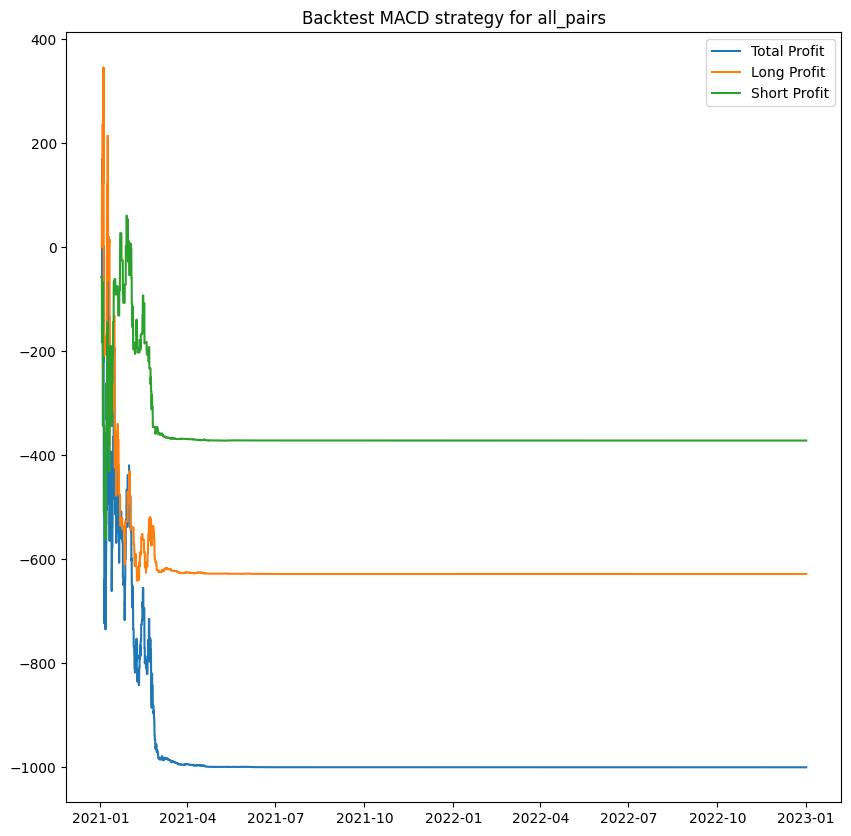

Creating all positions and timeserie graph ✅
#################################################################
#     Overview:                           |                     #
#     From 2021-01-01                     |     Value           #
#     To 2023-01-01                       |                     #
#     With 1000 $ starting                |                     #
#################################################################
#     Realized profit                     |     -1000.0 $       #
# ------------------------------------------------------------- #
#     Average profit / trade              |     -0.46 $         #
# ------------------------------------------------------------- #
#     Average profit / trade (%)          |     -0.18 %         #
# ------------------------------------------------------------- #
#     Profits std dev                     |     17.79 $         #
# ------------------------------------------------------------- #
#     Profits std dev (%)      

In [9]:
strat = EMA(
    exchange = 'binance',
    strategy_name = 'MACD',
    candle = '1h',
    list_pair = ['BTCUSDT', 'ETHUSDT', 'ADAUSDT', 'SOLUSDT', 'DOGEUSDT'],
    start =  datetime(2021, 1, 1),
    end =  datetime(2023, 1, 1),
    start_bk = 1000,
    leverage = 5,
    max_pos = 2,
    max_holding = timedelta(hours=12),
    quote_asset = 'USDT',
    geometric_sizes = True,
    save_all_pairs_charts = False,
    plot_exposure = False,
    key = "",
    secret = "",
    passphrase = "",
    tp_sl_delta = 0.05
)

stats = strat.run_backtest(save=False)